In [2]:
from pandas import read_csv

def read_data(file_path, num_features = 2, have_time = False):
    series_influ_A_df = read_csv(file_path, engine='python')
    series_influ_A_df = series_influ_A_df.rename(columns= {"Influenza A - All types of surveillance": "case"})

    # because since 2011-03-01 It was announced that the H1N12009 flu had been controlled and treated as regular seasonal flu and
    # since 2020-02-01, it's time for covid 
    
    series_influ_A_df = series_influ_A_df.loc [(series_influ_A_df['Month'] >='2011-04-01') & (series_influ_A_df['Month'] <='2020-02-01')]
    if not have_time:
        return series_influ_A_df.dropna()[["case", "temp", "dew", "tempmax", "humidity","tempmin","windspeed"][:num_features]]
    return series_influ_A_df.dropna()[["Month", "case", "temp", "dew", "tempmax", "humidity","tempmin","windspeed"][:num_features+1]]

file_path = '../temp_data/influA_vietnam_temp_month.csv'
#Load data set
df = read_data(file_path, have_time=True)



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

def calculate_errors(y_true, y_pred):
    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    
    # Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)
    
    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    
    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    # Root Mean Squared Percentage Error (RMSPE)
    rmspe = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))) * 100
    
    # Mean Absolute Residual (MARE)
    mare = np.mean(np.abs(y_true - y_pred))
    
    # Nash-Sutcliffe Efficiency (NSE)
    nse = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
    
    # Normalized Nash-Sutcliffe Efficiency (NNSE)
    nnse = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((np.abs(y_true - np.mean(y_true)) + np.abs(y_pred - np.mean(y_true))) ** 2))
    
    return mae, mse, rmse, mape, rmspe, mare, nse, nnse

In [4]:
def plot_r2(x,y, file_path=None):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy import stats

    # Generate some sample data
    # x = y_inverse.flatten()
    # y = y_hat_inverse.flatten()

    # Compute the linear regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    # Create the R-squared line
    r2_line = slope * x + intercept
    # r2 = r2_score(x, y)
    r2_pearson = r_value**2
    squared_error = np.square(x-y)

    # Print error metrics
    mae, mse, rmse, mape, rmspe, mare, nse, nnse = calculate_errors(x, y)
    print(f'MAE: {mae:.2f}')
    print(f'MSE: {mse:.2f}')
    print(f'RMSE: {rmse:.2f}')
    print(f'MAPE: {mape:.2f}%')
    print(f'RMSPE: {rmspe:.2f}%')
    print(f'MARE: {mare:.2f}')
    print(f'NSE: {nse:.2f}')
    print(f'NNSE: {nnse:.2f}')

    # Create the scatter plot
    plt.figure(figsize=(10, 12))

    # Subplot 1: Scatter plot and regression line
    plt.subplot(3, 1, 1)
    plt.scatter(x, y, label='Data Points')
    plt.plot(x, r2_line, color='red', marker="o", label=f'Regression line')
    plt.title('Correlation ')

    # Add labels and title
    plt.xlabel('actual number of infection')
    plt.ylabel('forecast number of infection')
    plt.title(f'Scatter Plot with R-squared Line\nCorrelation: {r_value:.2f}, R^2: {r2_pearson:.2f}')
    plt.legend()
    plt.grid()

    # Subplot 2: Real values over time
    plt.subplot(3, 1, 2)
    plt.plot( x, color='blue', label='Real_values')
    plt.xlabel('Time')
    plt.ylabel('Real_values')
    plt.title('Real Values over Time')
    plt.legend()
    plt.grid(True)
    
    # Subplot 3: Forecast values over time
    plt.subplot(3, 1, 3)
    plt.plot(y, color='green', label='Forecast_values')
    plt.xlabel('Time')
    plt.ylabel('Forecast_values')
    plt.title('Forecast Values over Time')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    # plt.savefig(file_path)
    # plt.close()
    plt.show()

In [5]:
df = df[["Month", "case"]]
new_df = df.set_index(keys="Month")

In [6]:
num_predict = 8
look_back = 8
test_size = num_predict
length = len(new_df)
dataset_length = length - (length -look_back) % num_predict
rest = length - dataset_length
dataset = new_df.iloc[rest:]
train = dataset.iloc[: -test_size]
test = dataset.iloc[-test_size:]

In [7]:
from utils import adf_test, check_acorr_ljungbox
adf_test(train)
check_acorr_ljungbox(train, lags=10)

Results of Dickey-Fuller Test:
Test Statistic                 -5.821927
p-value                         0.000005
#Lags Used                      3.000000
Number of Observations Used    92.000000
Critical Value (1%)            -4.060704
Critical Value (5%)            -3.459338
Critical Value (10%)           -3.155647
dtype: float64
      lb_stat     lb_pvalue
1   49.668146  1.820782e-12
2   62.134001  3.219386e-14
3   62.628650  1.612366e-13
4   65.710060  1.823329e-13
5   72.902334  2.547629e-14
6   82.508104  1.082786e-15
7   91.236101  6.894752e-17
8   95.116761  4.235054e-17
9   95.223650  1.449505e-16
10  96.333777  2.944233e-16
Có tự tương quan với lag 1
Có tự tương quan với lag 2
Có tự tương quan với lag 3
Có tự tương quan với lag 4
Có tự tương quan với lag 5
Có tự tương quan với lag 6
Có tự tương quan với lag 7
Có tự tương quan với lag 8
Có tự tương quan với lag 9
Có tự tương quan với lag 10


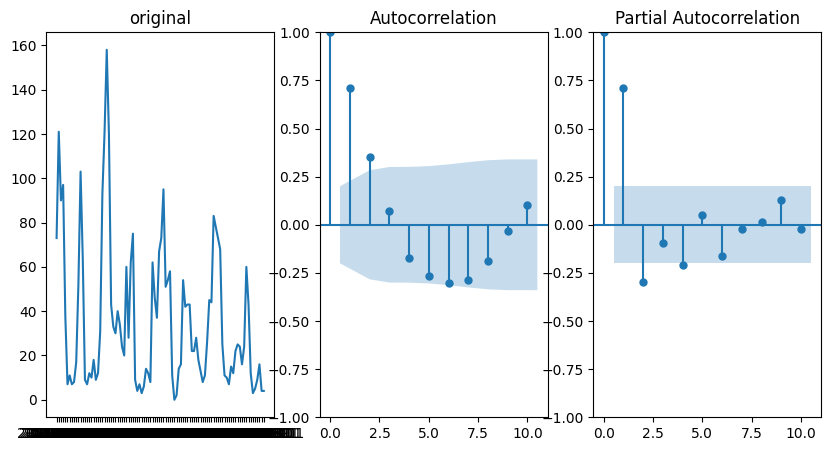

In [8]:
# Original Series
import statsmodels.api as sm
import matplotlib.pyplot as plt

# PACF plot of 1st differenced series
# plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 3, figsize=(10,5))
axes[0].plot(train); axes[0].set_title('original')
# axes[1].set(ylim=(0,5))
sm.graphics.tsa.plot_acf(train.dropna(), ax=axes[1], lags=10)
sm.graphics.tsa.plot_pacf(train.dropna(), ax=axes[2], lags=10)

plt.show()

In [9]:
# How to build the ARIMA Model 

import pmdarima as pm

model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=10, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                    #   trend='c',
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
# chọn được p,d,q là 2,0,2

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=885.918, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1020.299, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=886.893, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=935.328, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=886.129, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=887.791, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=916.851, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=886.096, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=887.992, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=875.518, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=886.448, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=879.875, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=871.701, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=873.989, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=873.

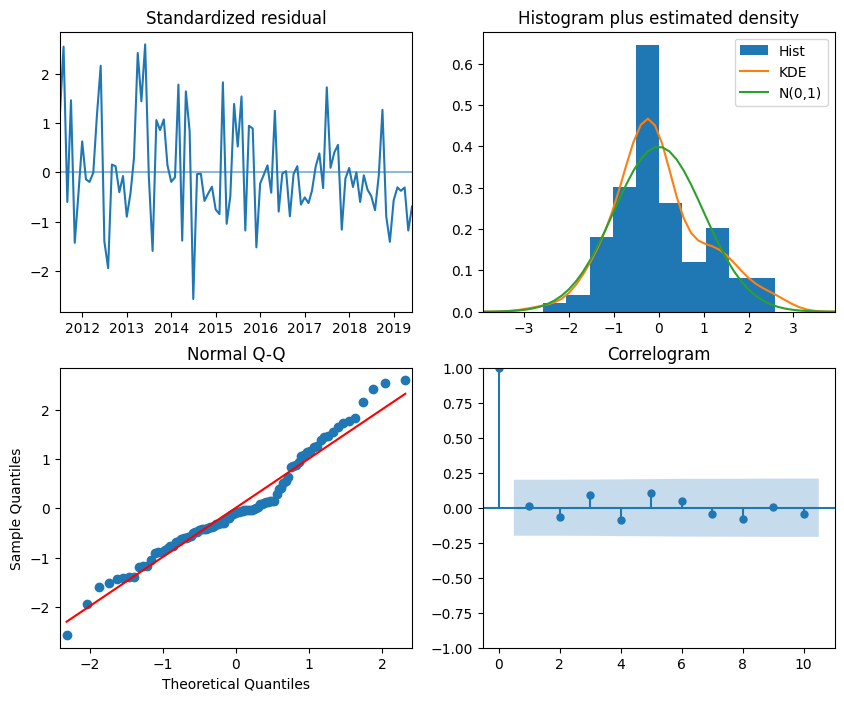

In [10]:
# import pandas as pd
# # Plot residual errors
# residuals = pd.DataFrame(model.resid)
# fig, ax = plt.subplots(1,3)
# residuals.plot(title="Residuals", ax=ax[0])
# # residuals.plot(kind='kde', title='Density', ax=ax[1])
# sm.graphics.tsa.plot_acf(residuals, ax=ax[1], lags=10)
# sm.graphics.tsa.plot_pacf(residuals, ax=ax[2], lags=10)
# plt.show()
model.plot_diagnostics(figsize=(10,8))
plt.show()

d:\my_study\gr3\DATN\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\my_study\gr3\DATN\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\my_study\gr3\DATN\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   case   No. Observations:                   96
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -430.851
Date:                Fri, 28 Jun 2024   AIC                            871.701
Time:                        11:19:00   BIC                            884.523
Sample:                    07-01-2011   HQIC                           876.884
                         - 06-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.5385      4.556      7.800      0.000      26.609      44.468
ar.L1          1.4882      0.154      9.681      0.000       1.187       1.789
ar.L2         -0.6962      0.113     -6.148      0.0

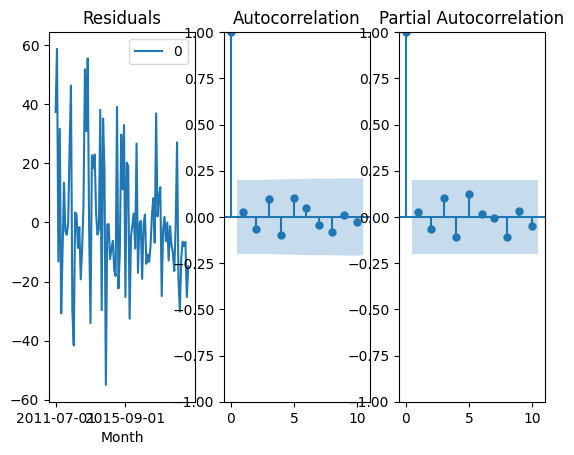

In [11]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
model = ARIMA(train, order=(2,0,1))

# dùng lbfgs để ước lượng tham số maximum likelyhood
model_fit = model.fit()
print(model_fit.summary())

# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,3)
residuals.plot(title="Residuals", ax=ax[0])
# residuals.plot(kind='kde', title='Density', ax=ax[1])
sm.graphics.tsa.plot_acf(residuals, ax=ax[1], lags=10)
sm.graphics.tsa.plot_pacf(residuals, ax=ax[2], lags=10)
plt.show()

In [12]:
print("================ check residual ===================")
adf_test(residuals)

check_acorr_ljungbox(residuals, lags=10)
print("================ check residual ===================")

================ check residual ===================
Results of Dickey-Fuller Test:
Test Statistic                -9.892349e+00
p-value                        3.910644e-15
#Lags Used                     0.000000e+00
Number of Observations Used    9.500000e+01
Critical Value (1%)           -4.057372e+00
Critical Value (5%)           -3.457759e+00
Critical Value (10%)          -3.154728e+00
dtype: float64
     lb_stat  lb_pvalue
1   0.072188   0.788177
2   0.496196   0.780283
3   1.462430   0.690968
4   2.439551   0.655492
5   3.475286   0.627130
6   3.738693   0.711989
7   3.930255   0.787775
8   4.596065   0.799747
9   4.606008   0.867214
10  4.704950   0.909997
Khong co tự tương quan đến lags =  10
================ check residual ===================


d:\my_study\gr3\DATN\venv\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


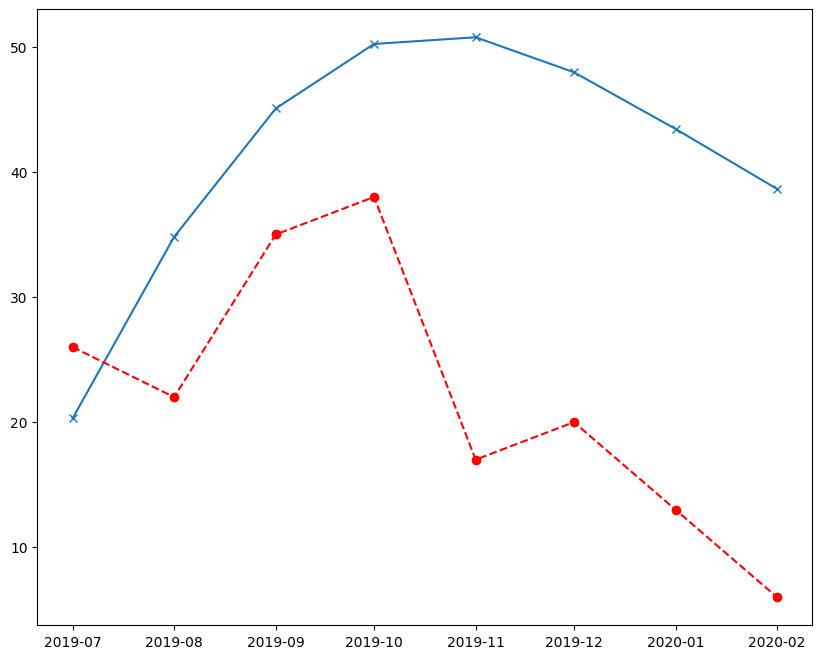

In [13]:
fc = model_fit.forecast(len(test), alpha=0.05)
fc_df = pd.DataFrame(fc).reset_index().rename(columns={'index': 'Month', 'predicted_mean': 'case'})
# test_df =  pd.DataFrame(test).reset_index()
# fc_df["Month"] = test_df["Month"]
plt.figure(figsize=(10,8))
plt.plot(fc_df['Month'], fc_df['case'], label='Actual', marker='x')
plt.plot(fc_df['Month'], test['case'], color='red', linestyle='--', label='Forecast', marker='o')
plt.show()

MAE: 20.70
MSE: 545.24
RMSE: 23.35
MAPE: 157.22%
RMSPE: 227.90%
MARE: 20.70
NSE: -4.41
NNSE: 0.40


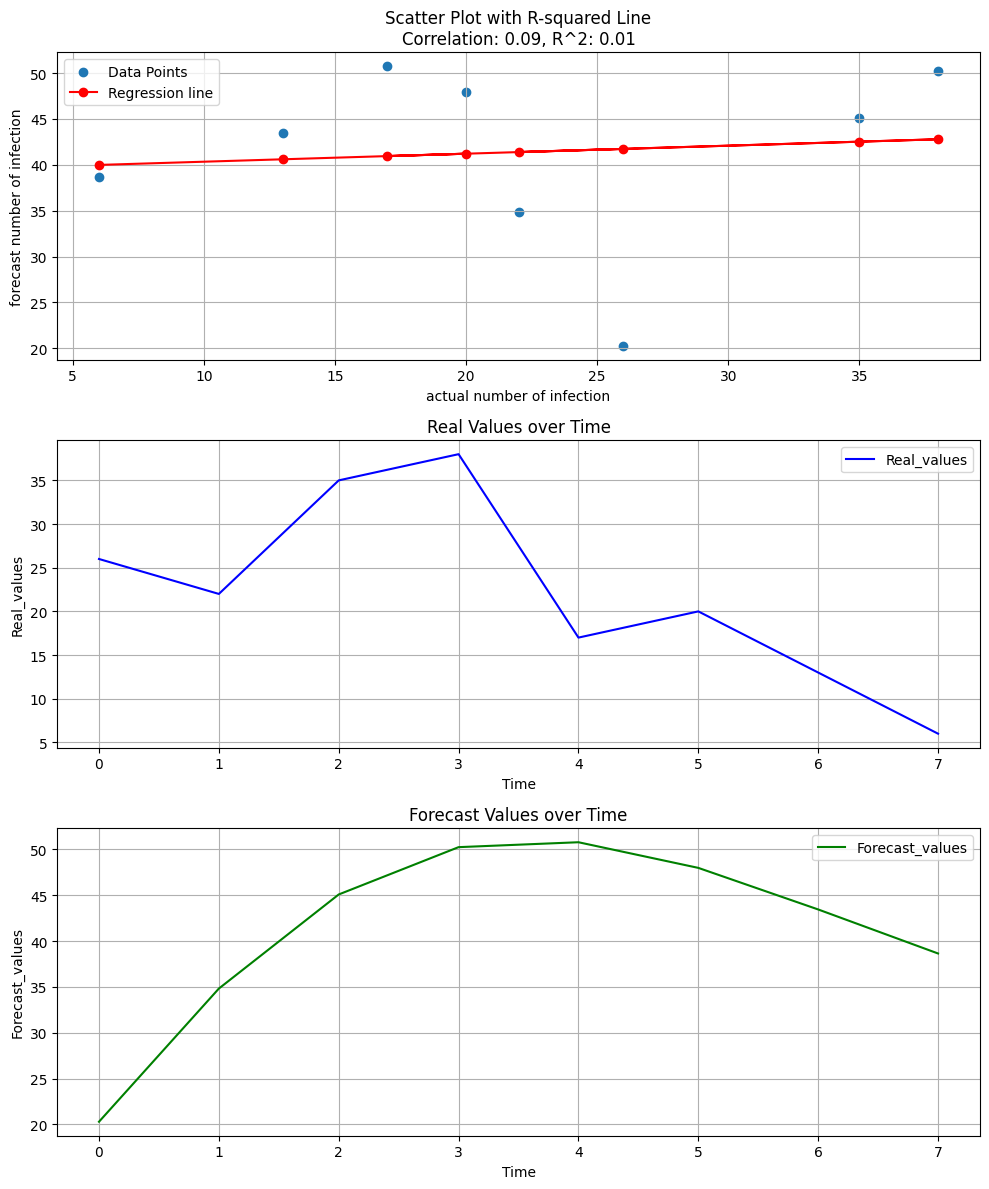

In [14]:
plot_r2(test['case'].values, fc_df['case'].values)

In [15]:
import statsmodels.api as sm

[]

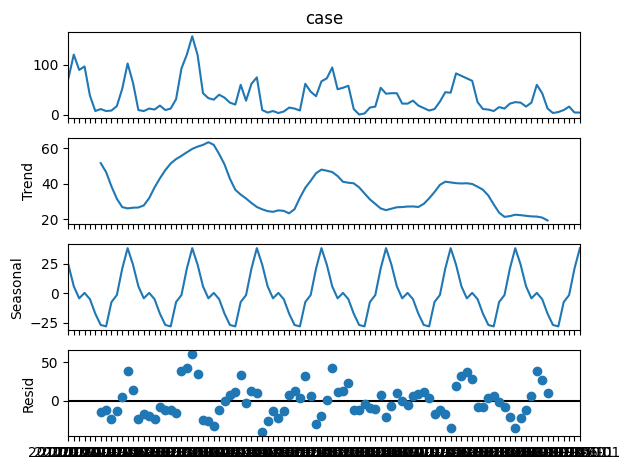

In [16]:
dec = sm.tsa.seasonal_decompose(train["case"], period=12).plot()
plt.plot()

In [17]:
from pmdarima.arima import auto_arima

model_sarima = auto_arima(train, start_p=2, start_q=1,
                           max_p=5, max_q=5, m=12,
                           start_P=1, seasonal=True,
                           start_Q=1,
                           max_P=3,max_Q=3, max_D=3,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

# print(model_sarima.aic())

Performing stepwise search to minimize aic
 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=946.306, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=874.518, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=885.332, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1020.299, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=879.875, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=876.321, Time=0.27 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=876.390, Time=0.16 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=875.788, Time=0.09 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=943.119, Time=0.09 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=871.586, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=873.989, Time=0.07 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=873.510, Time=0.33 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : A

In [18]:
model_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   96
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -430.793
Date:                            Fri, 28 Jun 2024   AIC                            871.586
Time:                                    11:19:07   BIC                            884.408
Sample:                                07-01-2011   HQIC                           876.769
                                     - 06-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.5148      4.444      2.141      0.032       0.805      18.225
ar.L1          0.8930      0.100      8.901      0.000       0.696       1.090
ar.L2         -0.2439      0.093     -2.629      0.009      -0.426      -0.062
ar.S.L12       0.2343      0.091      2.574      0.010       0.056       0.413
sigma2       455.3614     62.126      7.330      0.000     333.597     577.125
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 3.31
Prob(Q):                              0.91   Prob(JB):                         0.19
Heteroskedasticity (H):               0.28   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

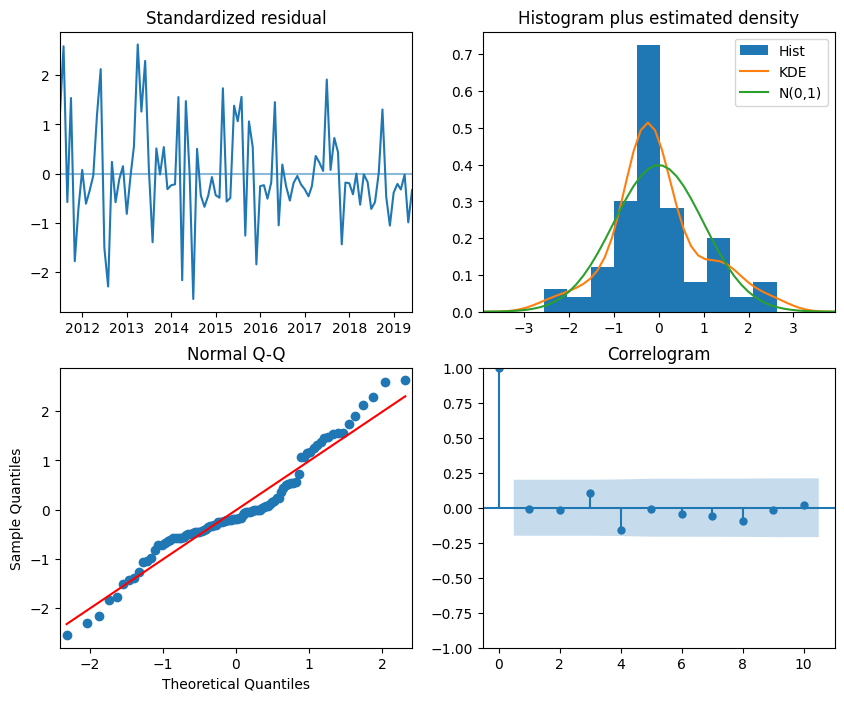

In [19]:
model_sarima.plot_diagnostics(figsize=(10,8))
plt.show()

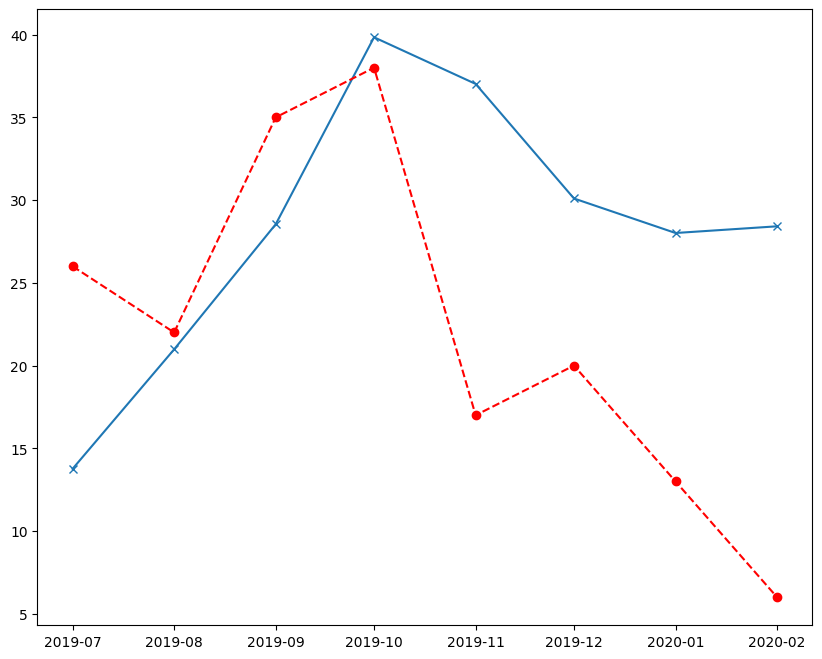

In [20]:
season_fc = model_sarima.predict(n_periods=len(test), alpha=0.05)
season_fc_df = pd.DataFrame(season_fc).reset_index().rename(columns={'index': 'Month', 0: 'case'})
plt.figure(figsize=(10,8))
plt.plot(season_fc_df['Month'], season_fc_df['case'], label='Actual', marker='x')
plt.plot(season_fc_df['Month'], test['case'], color='red', linestyle='--', label='Forecast', marker='o')
plt.show()


MAE: 11.14
MSE: 178.30
RMSE: 13.35
MAPE: 91.54%
RMSPE: 146.60%
MARE: 11.14
NSE: -0.77
NNSE: 0.51


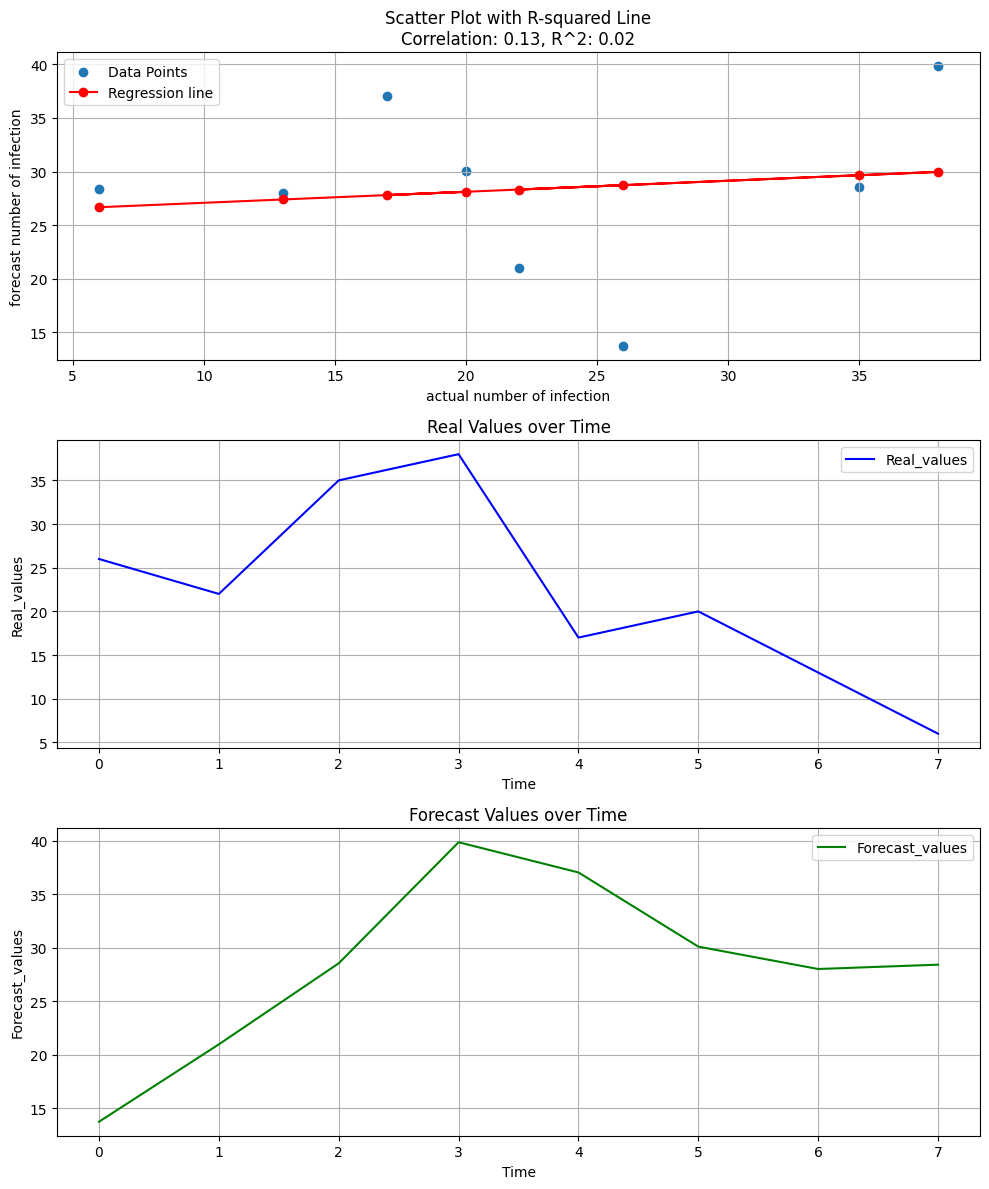

In [21]:
plot_r2(test['case'].values, season_fc_df['case'].values)

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
import numpy as np
def calculate_err(y_true, y_pred):
    # Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)
    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    return mse, rmse

In [23]:

season_fc_np = season_fc_df['case'].to_numpy()
test_np = test['case'].to_numpy()
season_mse, season_rmse = calculate_err(test_np, season_fc_np)
print("MSE: ", season_mse, "RMSE: ", season_rmse)


MSE:  178.30150543048524 RMSE:  13.352958677030541
